In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

import matplotlib.pyplot as plt
import numpy as np

import torch

from transformers import GPT2Tokenizer, GPT2LMHeadModel

from transformer_geometrical_analysis.utils.retrieval import get_activations, extract_weights

In [2]:
gpt2_version = "openai-community/gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(gpt2_version)
model = GPT2LMHeadModel.from_pretrained(gpt2_version, output_hidden_states=True, return_dict_in_generate=True)

In [3]:
# constants of the model
TOTAL_VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIMENTIONS = 768
MAXIMUM_INPUT_LENGTH = 1024
N_BLOCKS = 12

In [4]:
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [5]:
# generating random prompts of a fixed token size
n_tokens = 100
n_prompts = 100
prompts = [torch.randint(0, TOTAL_VOCAB_SIZE, size = (1, n_tokens)) for _ in range(n_prompts)]

In [6]:
# registering the hooks and initializing the dict to store all activations
activations = get_activations(model)

In [7]:
# runnning all the prompts to obtain all activations
for prompt in prompts:
    with torch.no_grad():
        _ = model(prompt)

In [8]:
# extracting all the weights from the transformer
weights = extract_weights(model)

#####

BLOCK 0

#####



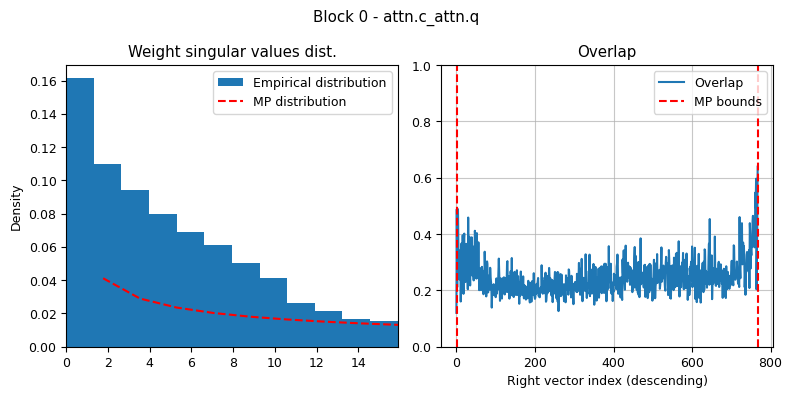

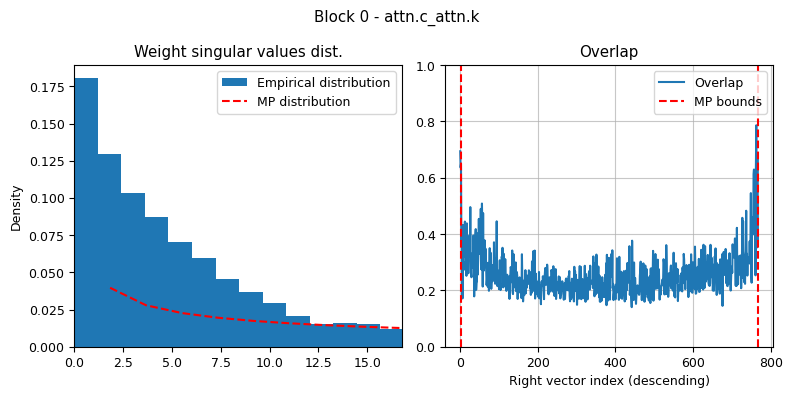

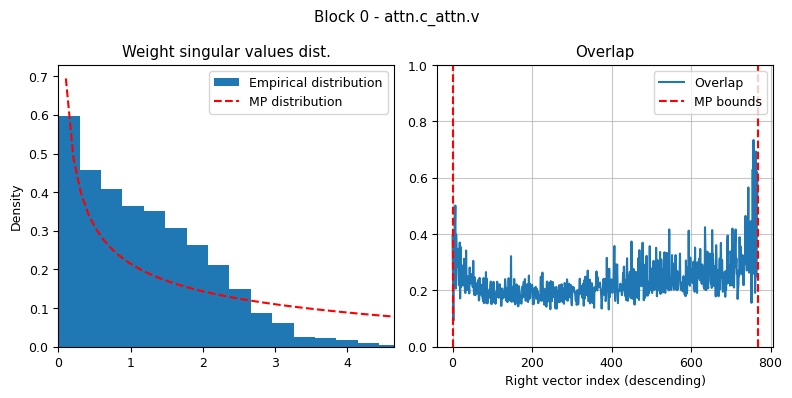

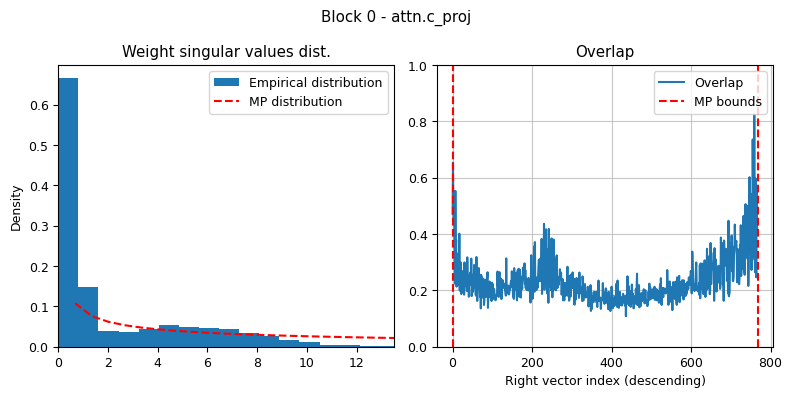

** On entry to SSYEVD, parameter number  8 had an illegal value


RuntimeError: false INTERNAL ASSERT FAILED at "/Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp":1602, please report a bug to PyTorch. linalg.eigh: Argument 8 has illegal value. Most certainly there is a bug in the implementation calling the backend library.

In [ ]:
for block_idx in range(N_BLOCKS):

    print("#####\n")
    print(f"BLOCK {block_idx}\n")
    print("#####\n")

    def slice_acts(key):
        """
        Function that returns all entries in `activations[key]` that correspond to the current `block_idx`
        """
        acts = activations[key]
        current_block_acts = []
        for i in range(n_prompts):
            selected_act = acts[i * N_BLOCKS + block_idx]
            n, d = selected_act.shape
            current_block_acts.append(selected_act.reshape(1,n,d))
        return torch.cat(current_block_acts, dim=0)
    

    # dict containing all weights and activations for each sublayer of the current `block_idx`
    sublayers = {
        sublayer: {"W": weights[f"h.{block_idx}.{sublayer}.weight"],"X": slice_acts(sublayer)} for sublayer in activations.keys()
    }

    # performs the decomposition and analysis of only the layers specified
    sublayer_selection = [
        "attn.c_attn.q",
        "attn.c_attn.k",
        "attn.c_attn.v",
        "attn.c_proj",
        "mlp.c_fc",
        "mlp.c_proj"
    ]

    for name, info in sublayers.items():
        if name not in sublayer_selection: continue

        W = info["W"] # weights
        X = info["X"] # buffers
        _, N, D = X.shape # the first dimention is n_prompt

        ###

        # computing the activation covariance matrix as defined in the paper
        x_mean = torch.mean(X, dim = [0,1])
        x_centered = X - x_mean
        act_cov = torch.sum(torch.matmul(torch.transpose(x_centered, 1, 2), x_centered), dim = 0) / (n_prompts * (N - 1))
        
        act_cov_eigvals, act_cov_eigvecs = torch.linalg.eigh(act_cov)
        
        # inverting the ordering (now descending)
        act_cov_eigvals = act_cov_eigvals.flip(0)
        act_cov_eigvecs = act_cov_eigvecs.flip(1)

        ###

        # computing the SVD of the weights
        max_rank = np.min(W.shape)
        _, svals, Vt = torch.linalg.svd(W, full_matrices=True)

        # removing all eigenvalues we are sure to be 0
        w_svals = svals[:max_rank]
        w_rvecs = Vt[:,:max_rank]

        # and the corresponding eigenvectors in the act_cov
        act_cov_eigvals = act_cov_eigvals[:max_rank]
        act_cov_eigvecs = act_cov_eigvecs[:,:max_rank]

        ### 

        # computing the overlap between w and act eigvecs
        # this could signify how much information is transfered from the weights to the buffer
        overlap = torch.max(torch.matmul(w_rvecs, act_cov_eigvecs), dim = 0)[0]

        ###

        # marchenko-pastur parameters
        sigma = torch.std(W)*np.sqrt(D)
        ratio = W.shape[1] / W.shape[0]
        l_upper = (sigma * (1 + np.sqrt(ratio)))**2
        l_lower = (sigma * (1 - np.sqrt(ratio)))**2

        def mp_distribution(x):
            """
            Marchenko-Pastur distribution
            """
            return torch.sqrt((l_upper - x) * (x - l_lower)) / (2 * torch.pi * sigma**2 * ratio * x)

        x_mp = torch.linspace(l_lower, l_upper, 100) 
        # the first element is removed because if 0 it leads to division error
        if (x_mp[0] < 1e-6):
            x_mp = x_mp[1:]
        mp = mp_distribution(x_mp)
        mp = mp / torch.trapezoid(mp, x_mp) # renormalizing the distribution

        # finding the bordering eigvalues w.r.t. the mp distribution
        eigvals_in_mp_range = torch.logical_and(w_svals > l_lower, w_svals < l_upper)
        idx_lower = w_svals.shape[0] - torch.argmin(torch.arange(w_svals.shape[0])[eigvals_in_mp_range])
        idx_upper = w_svals.shape[0] - torch.argmax(torch.arange(w_svals.shape[0])[eigvals_in_mp_range])

        svals_in_mp_range = torch.logical_and(w_svals > l_lower, w_svals < l_upper)
        idx_lower = svals.shape[0] - torch.argmin(torch.arange(svals.shape[0])[svals_in_mp_range])
        idx_upper = svals.shape[0] - torch.argmax(torch.arange(svals.shape[0])[svals_in_mp_range])

        ###

        # plotting 
        counts, bins = np.histogram(w_svals.detach().numpy(), bins = "fd", density=True, range = [0, max(w_svals.detach().numpy())])
        counts, bins = np.histogram(w_svals.detach().numpy(), bins = "fd", density=True, range = [0, max(w_svals.detach().numpy())])


        plt.rcParams.update({'font.size': 9})
        fig, axs = plt.subplots(ncols=2, figsize = (8, 4))

        # w_cov eigenvalues distribution plot
        axs[0].hist(bins[:-1], bins, weights = counts, label = "Empirical distribution")
        axs[0].plot(x_mp, mp, linestyle = "--", color = "r", label = "MP distribution")
        axs[0].set_xlim(0, torch.quantile(w_svals, 0.99))
        axs[0].set_title("Weight singular values dist.")
        axs[0].set_ylabel("Density")
        axs[0].legend()

        # overlap plot
        axs[1].plot(overlap, label = "Overlap")
        axs[1].vlines(x = [idx_lower, idx_upper], ymin = 0, ymax = 1, color = "r", linestyle = "--", label = "MP bounds")
        axs[1].grid(alpha = 0.7)
        axs[1].set_ylim(0,1)
        axs[1].set_title("Overlap")
        axs[1].set_xlabel("Right vector index (descending)")
        axs[1].legend()

        fig.suptitle(f"Block {block_idx} - {name}")
        fig.tight_layout()
        plt.show()